In [3]:
%load_ext autoreload
%autoreload 2

from evaluation_scripts.base import load_json, get_base_pathes
import os
from evaluation_scripts.base import load_pickle_obj
from model_scripts.sensitivity_evaluation import SensitivityAnalysis, summarize_evaluations, count_strategy, collect_stats, get_shared
from model_scripts.wins_and_losses import WinsAndLosses, set_title, set_common_ylabel
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd


_, base = get_base_pathes()
path = os.path.join(base, "sensitivity_sim")

name_add = "_no_preex"

In [4]:
sensitivity = SensitivityAnalysis(path, parameter_names = ["turnover",
                                "infection", "cA", "cB", "cS", "cU", "cAB"], name_add = name_add)
reload = True
if reload:
    sensitivity.load()
else:
    sims = pd.read_pickle(os.path.join(path, "sensitivity_sim"+name_add+".pkl"))
    pars = pd.read_pickle(os.path.join(path, "sensitivity_par"+name_add+".pkl"))
    sensitivity.evaluate_parameter_sets(sims, pars)
    sensitivity.save()

In [5]:
df = summarize_evaluations(sensitivity.evaluations)


results = []
for strategy in ["Combination", "Cycling", "Mixing", "Mono A", "Mono B"]:
    results.append(count_strategy(df, strategy))
results = pd.DataFrame().from_records(results)
results = results.set_index("strategy")

insignificant = df.apply(lambda x: get_shared(x, "worst_", None), axis = 1).sum()

print("Num of insignificant scenarios: ", insignificant)

results

Num of insignificant scenarios:  100


,single_winner,single_loser,loser,winner
strategy,,,,
Combination,9311,0,0,9835
Cycling,4,8,1889,349
Mixing,1,1,2205,132
Mono A,56,2648,5703,165
Mono B,0,4132,6344,111


In [6]:
results_rel = results.copy()
results_rel = results_rel * 100 / len(sensitivity.evaluations)
results_rel

,single_winner,single_loser,loser,winner
strategy,,,,
Combination,93.11,0.00,0.00,98.35
Cycling,0.04,0.08,18.89,3.49
Mixing,0.01,0.01,22.05,1.32
Mono A,0.56,26.48,57.03,1.65
Mono B,0.00,41.32,63.44,1.11


In [7]:
color_1 = ["#FFA500", "#FF8C00", "#FF6347"]
color_2 = ["#00CED1", "#40E0D0", "#20B2AA"]
colors = {
    "single_win":"#5779B7", 
    "total_win":"#8DACD6",
    "single_loss":"#B74A4A", 
    "total_loss":"#D68A8A",
}

file_path = os.path.join(base, "summary", "exp_anova_no_notreat.json")
exp_results = load_json(file_path)
exp_results = [exp_results[0], exp_results[2]]

/Users/malte/ETH-Documents/TSP-Collection/TSPlasmids_main/JupyterScripts/model_scripts/wins_and_losses.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(int(label)) for label in ax.get_yticks()])


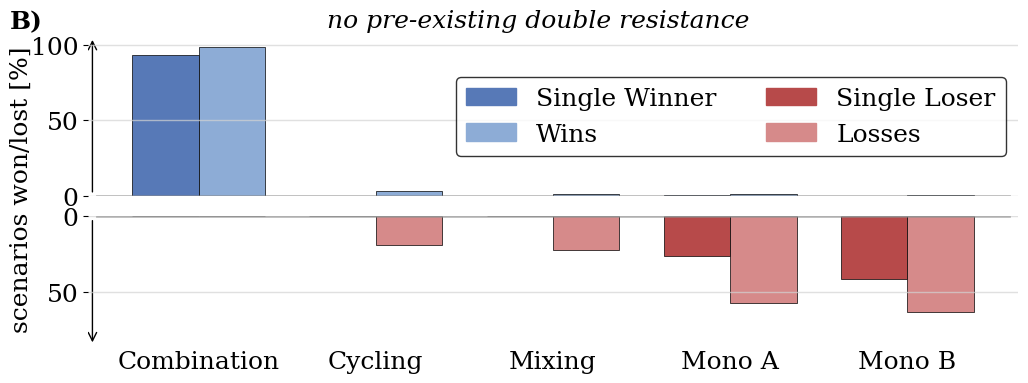

In [20]:
fontsize = 18
from figures import Figure, styles
figure = Figure(styles["paper"])

WandL = WinsAndLosses(results_rel, path, colors, fontsize=fontsize, axes_label_fontsize=fontsize, y_label_x = -.1, figsize=(12, 4))
#WandL.add_exp_results(exp_results)
fig, axs = WandL.plot(title = None, legend = True, hspace = .14)
set_title(fig, "B)", "no pre-existing double resistance", title_y = .95, family = "serif", fontsize = fontsize)
set_common_ylabel(fig, axs, "scenarios won/lost [%]", fontsize = fontsize)
for ax in axs:
    figure.format_labels(ax, fontsize= fontsize)
    figure.format_ticks(ax, fontsize= fontsize)
    figure.format_legend(ax, fontsize= fontsize)
    figure.format_annotations(ax, fontsize= fontsize)
WandL.save(path, name_add = name_add)


In [8]:
results_df = results_rel.copy()
results_df = results_df.rename(columns=lambda x: x + " [\%]")
results_df = results_df.join(results)
results_df.columns = [col.replace('_', ' ') for col in results_df.columns]
results_df.to_latex(os.path.join(base, "tables", "win_loss_statistic"+name_add+".tex"),
                   float_format="%.2f")
results_df

,single winner [\%],single loser [\%],loser [\%],winner [\%],single winner,single loser,loser,winner
strategy,,,,,,,,
Combination,93.11,0.00,0.00,98.35,9311,0,0,9835
Cycling,0.04,0.08,18.89,3.49,4,8,1889,349
Mixing,0.01,0.01,22.05,1.32,1,1,2205,132
Mono A,0.56,26.48,57.03,1.65,56,2648,5703,165
Mono B,0.00,41.32,63.44,1.11,0,4132,6344,111


In [9]:
insignificant

100

In [10]:
worst_stats = collect_stats(df, "worst")
worst_stats.columns = [col.replace('_', '\_') for col in worst_stats.columns]
best_stats = collect_stats(df, "best")
best_stats.columns = [col.replace('_', '\_') for col in best_stats.columns]
worst_stats.to_latex(os.path.join(base, "tables", "worst_stats"+name_add+".tex"),
                   float_format="%.2f")
best_stats.to_latex(os.path.join(base, "tables", "best_stats"+name_add+".tex"),
                   float_format="%.2f")
display(worst_stats)
display(best_stats)

,turnover,infection,U,S,A\_r,B\_r,AB\_r,n
Mono B,0.600152,0.427115,0.260131,0.246878,0.162759,0.330232,0.0,4132.0
Mono A,0.547549,0.426057,0.274052,0.245891,0.360517,0.119539,0.0,2648.0
Cycling,0.071250,0.871250,0.282500,0.338750,0.266250,0.112500,0.0,8.0
Mixing,0.070000,0.900000,0.690000,0.250000,0.010000,0.050000,0.0,1.0


,turnover,infection,U,S,A\_r,B\_r,AB\_r,n
Combination,0.504427,0.503298,0.262063,0.243798,0.244184,0.249955,0.0,9311.0
Mono A,0.802679,0.265714,0.261786,0.294464,0.366786,0.076964,0.0,56.0
Cycling,0.097500,0.390000,0.332500,0.422500,0.142500,0.102500,0.0,4.0
Mixing,0.110000,0.330000,0.120000,0.490000,0.380000,0.010000,0.0,1.0
